In [1]:
import sys

sys.path.append('../../')

import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import keras.backend as K
from Pipeline.Multi_task.cross_stitch_block import CrossStitch
from keras.layers import Dense, Conv1D, MaxPool1D, Lambda
from keras import Input, Model
from keras import Sequential

from Pipeline.tf_dataset_builder import DatasetBuilderRaw
from Pipeline.tf_lite_utils import predict_tflite_mtl, convert_tf_lite_mtl
from Pipeline.evaluation import plot_confusion_matrix, detection_report

C:\Users\loren\anaconda3\envs\tinyML-thesis\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# Set seed for experiment reproducibility
seed = 1
tf.random.set_seed(seed)

In [3]:
# Define paths to model files
MODELS_DIR = '../../Models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'cross_stitch_model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'cross_stitch_model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'cross_stitch_model.tflite'

In [4]:
class_dict = {
    'Background': 0,
    'Big mandibles': 1,
    'Small mandibles': 2,
}

In [5]:
# Set hyperparameters
batch_size = 64
learning_rate = 0.0005
epochs = 100
patience = 5
gamma = 0.5

In [6]:
# Load the data: raw extraction
DatasetBuilder = DatasetBuilderRaw(
    #dataset_dir="../../Dataset/Generated dataset/Deployment/unstandardized/50ms/**/*.wav",
    dataset_dir="../../Dataset/Final dataset/Generation/Generated dataset/**/*.wav",
    batch_size=batch_size,
    class_dict=class_dict,
    augment=False,
    balanced=False,
    multi_task=True,
    normalize=True,
    seed=seed,
    sample_rate=44100
)
train_dataset, val_dataset, test_dataset = DatasetBuilder.build(val_split=0.2, test_split=0.2)

In [7]:
input_shape = test_dataset[0][0].shape
input_shape

(2205, 1)

In [8]:
def conv1D_block(filters, kernel_size, strides, pool_size):
    return Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding="same", activation='relu'),
        MaxPool1D(pool_size=pool_size, strides=strides),
    ])

In [9]:
input_layer = Input(shape=input_shape)
layer_1 = [
    MaxPool1D(pool_size=4, strides=2)(
        Conv1D(filters=8, kernel_size=80, padding="same", activation='relu')(input_layer)
    ),
    MaxPool1D(pool_size=4, strides=2)(
        Conv1D(filters=8, kernel_size=80, padding="same", activation='relu')(input_layer)
    ),
]
cs_block_1 = CrossStitch()(layer_1)
layer_2 = [
    conv1D_block(filters=8, kernel_size=3, pool_size=4, strides=2)(stitch) for stitch in cs_block_1
]
cs_block_2 = CrossStitch()(layer_2)
layer_3 = [
    conv1D_block(filters=8, kernel_size=3, pool_size=4, strides=2)(stitch) for stitch in cs_block_2
]
cs_block_3 = CrossStitch()(layer_3)
backbone = [
    Lambda(lambda x: K.mean(x, axis=1))(Dense(32, activation='relu')(stitch)) for stitch in cs_block_3
]

detection_head = Sequential([
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])
detection_head._name = 'detection'

classification_head = Sequential([
    Dense(32, activation='relu'),
    Dense(len(class_dict), activation='softmax'),
])
classification_head._name = 'classification'

output1 = detection_head(backbone[0])
output2 = classification_head(backbone[1])

multitask_model = Model(inputs=input_layer, outputs=[output1, output2])

In [10]:
multitask_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2205, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2205, 8)      648         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2205, 8)      648         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 1101, 8)      0           ['conv1d[0][0]']                 
                                                                                              

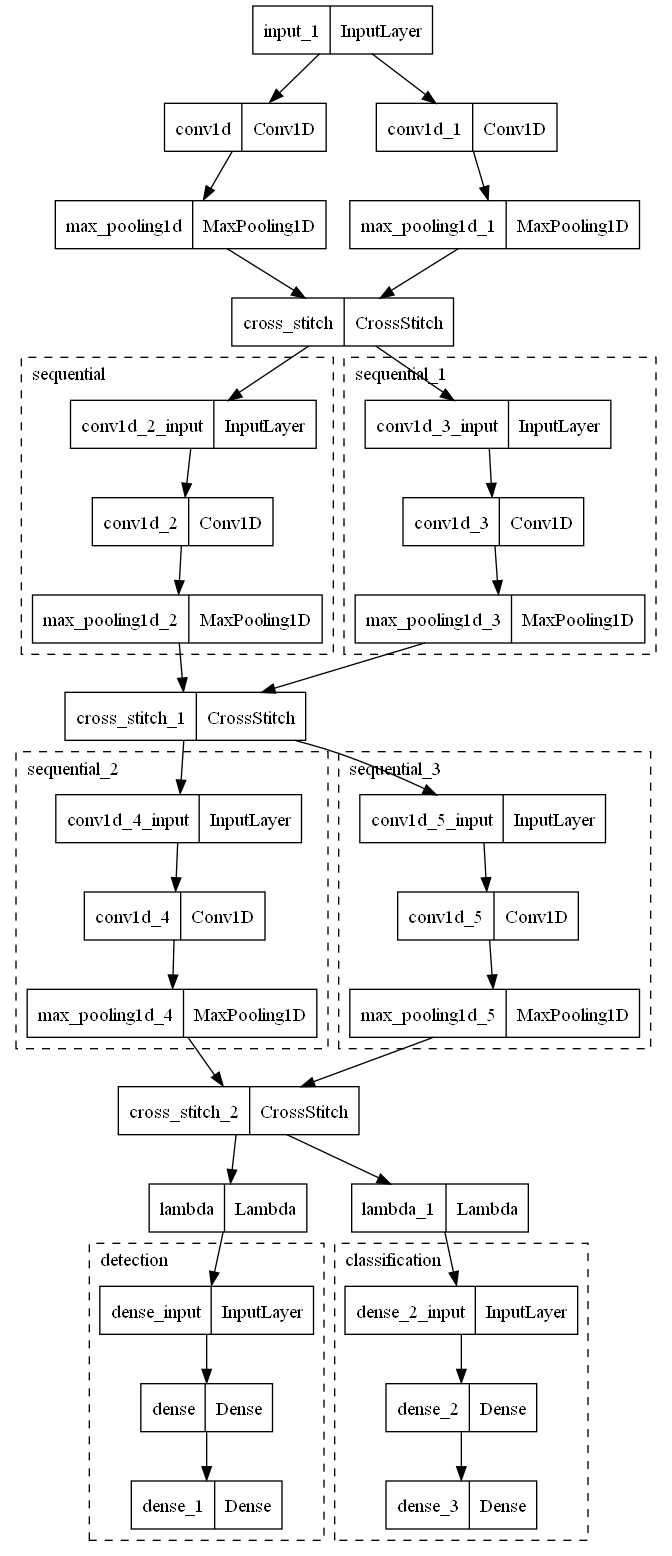

In [11]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
tf.keras.utils.plot_model(multitask_model, expand_nested=True)

In [11]:
loss1 = tf.keras.losses.BinaryCrossentropy()
loss2 = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

losses = {
    'detection': loss1,
    'classification': loss2
}

loss_weights = {
    'detection': gamma,
    'classification': 1 - gamma
}

metrics = ['accuracy']

multitask_model.compile(
    optimizer=optimizer,
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics,
)

In [12]:
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(verbose=1, patience=patience)

history = multitask_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/100
30/30 [==============================] - 5s 97ms/step - loss: 0.8882 - detection_loss: 0.6860 - classification_loss: 1.0903 - detection_accuracy: 0.5708 - classification_accuracy: 0.3427 - val_loss: 0.8761 - val_detection_loss: 0.6644 - val_classification_loss: 1.0879 - val_detection_accuracy: 0.6708 - val_classification_accuracy: 0.3375 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 3s 90ms/step - loss: 0.8668 - detection_loss: 0.6595 - classification_loss: 1.0740 - detection_accuracy: 0.6583 - classification_accuracy: 0.3646 - val_loss: 0.8547 - val_detection_loss: 0.6448 - val_classification_loss: 1.0646 - val_detection_accuracy: 0.6708 - val_classification_accuracy: 0.4187 - lr: 0.0010
Epoch 3/100
30/30 [==============================] - 3s 89ms/step - loss: 0.8440 - detection_loss: 0.6448 - classification_loss: 1.0433 - detection_accuracy: 0.6583 - classification_accuracy: 0.4536 - val_loss: 0.8240 - val_detection_loss: 0.6253 - val_classification_lo

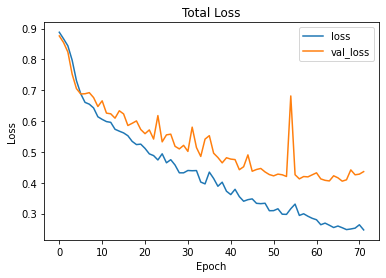

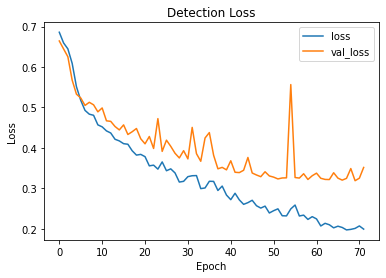

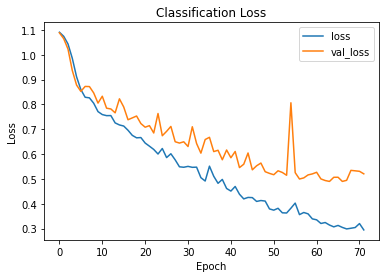

In [13]:
metrics = history.history
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

plt.title('Detection Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['detection_loss'], metrics['val_detection_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['classification_loss'], metrics['val_classification_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [14]:
test_features = test_dataset[0]
predictions = multitask_model.predict(test_features, verbose=1)

y_pred = np.rint(predictions[0]).astype(int).flatten()
y_true = test_dataset[1]['detection']

detection_report(y_true, y_pred)

19/19 [==============================] - 0s 14ms/step

Evaluation on the test set:
False alarm prob: 13.98%
Miss detection prob: 17.15%
Number of False Positives: 26
Number of False Negatives: 71
Detector f1-score is 87.611750%

Other Metrics:
Detector accuracy is 83.833333%
Detector precision is 92.953930%
Detector recall is 82.850242%


Classification test set accuracy: 80%


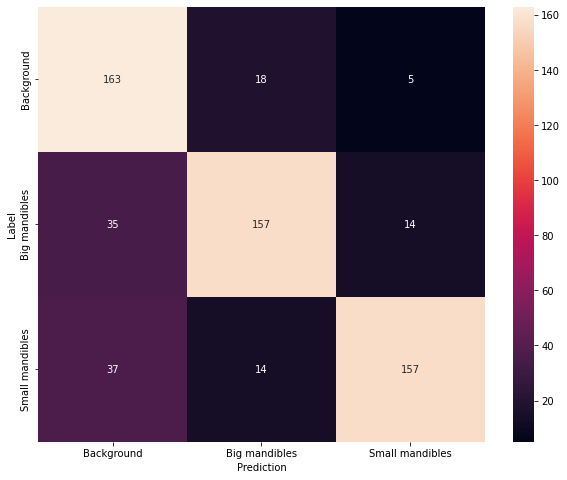

In [15]:
y_pred = np.argmax(predictions[1], axis=1)
y_true = test_dataset[1]['classification']

test_acc = accuracy_score(y_true=y_true, y_pred=y_pred)
print(f'Classification test set accuracy: {test_acc:.0%}')
plot_confusion_matrix(list(class_dict.keys()), y_true, y_pred)

In [16]:
def representative_dataset():
    for feature, label in train_dataset.take(100):
        yield {
            "input_1": feature.numpy(),
            "detection": label['detection'].numpy(),
            "classification": label['classification'].numpy(),
        }

In [17]:
# Compress the model
multitask_model.save(MODEL_TF)
# Define the input and output details for TensorFlow Lite
input_details = multitask_model.input
output_details = [multitask_model.output[0], multitask_model.output[1]]
# Convert to TensorFlow Lite model
convert_tf_lite_mtl(MODEL_TF, MODEL_TFLITE, representative_dataset, output_details)

INFO:tensorflow:Assets written to: ../../Models/cross_stitch_model\assets


INFO:tensorflow:Assets written to: ../../Models/cross_stitch_model\assets


Quantized model is 31264 bytes


In [18]:
y_pred_det, y_pred_class = predict_tflite_mtl(MODEL_TFLITE, test_features)

In [19]:
print("Quantized detection report:")
detection_report(test_dataset[1]['detection'], y_pred_det.flatten())

Quantized detection report:

Evaluation on the test set:
False alarm prob: 12.37%
Miss detection prob: 16.67%
Number of False Positives: 23
Number of False Negatives: 69
Detector f1-score is 88.235294%

Other Metrics:
Detector accuracy is 84.666667%
Detector precision is 93.750000%
Detector recall is 83.333333%


              precision    recall  f1-score   support

           0     0.7453    0.6452    0.6916       186
           1     0.4908    0.9078    0.6371       206
           2     1.0000    0.2788    0.4361       208

    accuracy                         0.6083       600
   macro avg     0.7454    0.6106    0.5883       600
weighted avg     0.7462    0.6083    0.5843       600



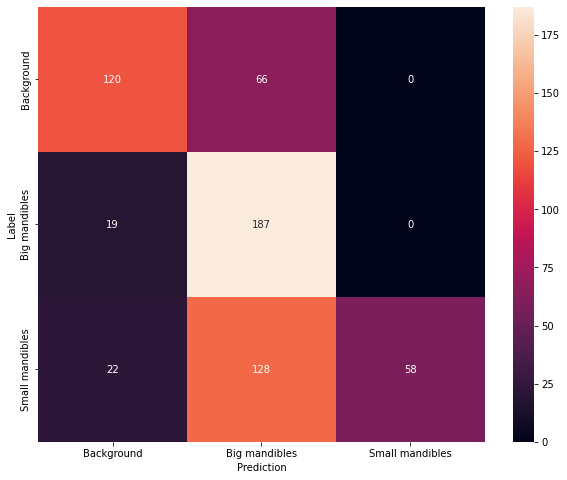

In [20]:
print(classification_report(test_dataset[1]['classification'], y_pred_class, digits=4))
plot_confusion_matrix(list(class_dict.keys()), test_dataset[1]['classification'], y_pred_class)